Visualize learned TRF coefficients.

In [1]:
from argparse import ArgumentParser, Namespace
from collections import defaultdict
from copy import deepcopy
import io
from itertools import product
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append(str(Path(".").resolve().parent.parent))
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
import berp.models.reindexing_regression as rr
from berp.viz.trf import trf_to_dataframe, plot_trf_coefficients

In [5]:
model_dirs = ["../../workflow/gillis2021/results/GroNLP/gpt2-small-dutch/trf-berp-fixed.20221201.normXvar/",]
stimulus_dir = "../../workflow/gillis2021/data/stimulus/GroNLP/gpt2-small-dutch/"
dataset_dir = "../../workflow/gillis2021/data/dataset/GroNLP/gpt2-small-dutch/"
subjects = ["2019_C2DNN_18", "2019_C2DNN_38"]
stories = ["DKZ_1", "DKZ_2", "DKZ_3"]

## Load results

In [6]:
# Load pipelines.
if len(model_dirs) > 1:
    raise NotImplementedError("not yet supporting multiple pipelines")

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
pipes = []
for run in model_dirs:
    pipeline_path = Path(run) / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        print(f"Missing pipeline at {pipeline_path}")

    with pipeline_path.open("rb") as f:
        pipes.append(CPU_Unpickler(f).load())
        # pipes.append(torch.load(f, map_location=torch.device("cpu")))
        
    # TODO shape checks etc.

# TODO support more than one pipeline
pipe = pipes[0]

In [7]:
# Load datasets.
target_sensors = ["C1", "Cz", "C2", "CP1", "CPz", "CP2"]
ds = {}
stimulus_paths = {story: Path(stimulus_dir) / f"{story}.pkl" for story in stories}
combs = list(product(stories, subjects))
for story, subject in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"{subject}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject] = load_eeg_dataset(
        [ds_path], subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=True, normalize_X_variable=False, normalize_Y=True).datasets[0]

  0%|          | 0/6 [00:00<?, ?it/s]

## Preprocessing

In [9]:
encoders = {subject: pipe.encoders_[subject] for subject in subjects}

In [20]:
sample_ds = next(iter(ds.values()))
ts_predictor_names, var_predictor_names = pipe.encoder_predictor_names
predictor_names = ts_predictor_names + var_predictor_names

In [24]:
coef_df = pd.concat({
    subject: trf_to_dataframe(encoder, predictor_names)
    for subject, encoder in encoders.items()
}, names=["subject", "x"])

In [25]:
coef_df

predictor  lag  sensor      coef  epoch_time  \
subject       x                                                    
2019_C2DNN_18 0             0    0       0  0.002748      0.0000   
              1             0    0       1  0.001999      0.0000   
              2             0    0       2  0.001295      0.0000   
              3             0    0       3  0.002549      0.0000   
              4             0    0       4  0.002271      0.0000   
...                       ...  ...     ...       ...         ...   
2019_C2DNN_38 9631         21   72       1  0.001498      0.5625   
              9632         21   72       2  0.001101      0.5625   
              9633         21   72       3  0.001358      0.5625   
              9634         21   72       4  0.001271      0.5625   
              9635         21   72       5  0.001011      0.5625   

                                      predictor_name  
subject       x                                       
2019_C2DNN_18 0     binned acoustical edges >100Hz_0  
              1     binned acoustical edges >100Hz_0  
              2     binned acoustical edges >100Hz_0  
              3     binned acoustical edges >100Hz_0  
              4     binned acoustical edges >100Hz_0  
...                                              ...  
2019_C2DNN_38 9631                var_word_frequency  
              9632                var_word_frequency  
              9633                var_word_frequency  
              9634                var_word_frequency  
              9635                var_word_frequency  

[19272 rows x 6 columns]

In [26]:
coef_df.predictor_name.unique()

array(['binned acoustical edges >100Hz_0',
       'binned acoustical edges >100Hz_1',
       'binned acoustical edges >100Hz_2',
       'binned acoustical edges >100Hz_3',
       'binned acoustical edges >100Hz_4',
       'binned acoustical edges >100Hz_5',
       'binned acoustical edges >100Hz_6',
       'binned acoustical edges >100Hz_7', 'phoneme onsets_0',
       'binned spectrogram >100Hz_0', 'binned spectrogram >100Hz_1',
       'binned spectrogram >100Hz_2', 'binned spectrogram >100Hz_3',
       'binned spectrogram >100Hz_4', 'binned spectrogram >100Hz_5',
       'binned spectrogram >100Hz_6', 'binned spectrogram >100Hz_7',
       'word onsets_0', 'phoneme_surprisal', 'phoneme_entropy',
       'var_word_surprisal', 'var_word_frequency'], dtype=object)

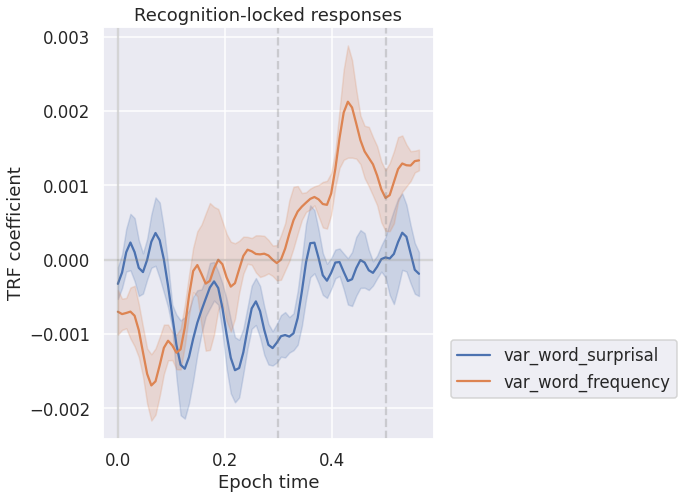

In [30]:
sns.set("talk")
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, predictor_match_patterns=["word_surprisal", "word_frequency",
                                                        "recognition_onset"])
plt.title("Recognition-locked responses")
None

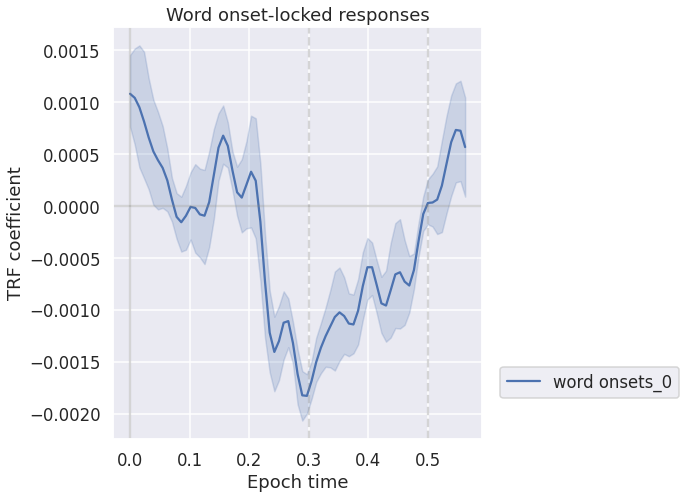

In [31]:
sns.set("talk")
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, predictor_match_patterns=["word onsets"])
plt.title("Word onset-locked responses")
None

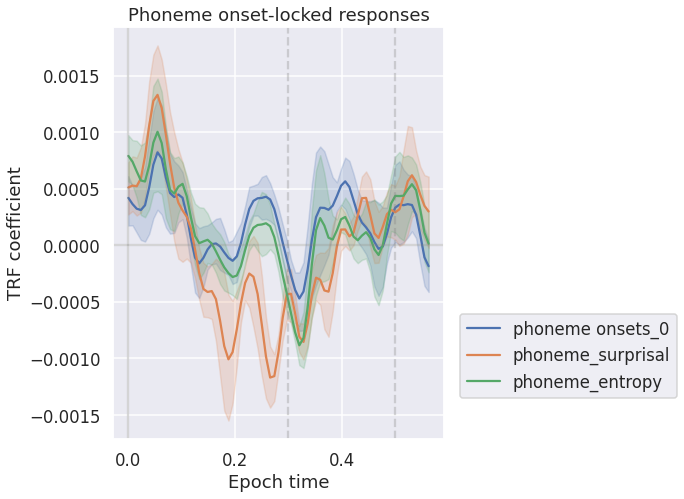

In [32]:
sns.set("talk")
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, predictor_match_patterns=["phoneme"])
plt.title("Phoneme onset-locked responses")
None